In [1]:
# Importing the different packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.integrate import quad

In [13]:
# Different Parameters

dt = 0.000001 # what is dt? is the sampling period in the time-domain
length = 10000 # length of what? length of the intensity signal
T = length*dt # time that signal covers
D = 1 # diffusion coefficient
sigma = 1 # standard deviation
L = 6*np.sqrt(2*D*T+sigma**2)# half of the beam spot size, the radius
N = int(4*L) # The number of particles

0.01

In [3]:
# initial positions
pos1 = 2*L*np.random.random(size=(N,))-L

In [4]:
# random walks that were pregenerated
# The matrix the same size of the number of particles by the total time is
# generated and then the stacks are combined
# The position at each point is found by taking the cumulative sum of the random kicks at each point in time
steps = np.random.normal(loc=0,scale=np.sqrt(2*D*dt),size=(N,length))
x = np.column_stack((pos1,steps))
path = np.mod(np.cumsum(x,axis=1),2*L)-L

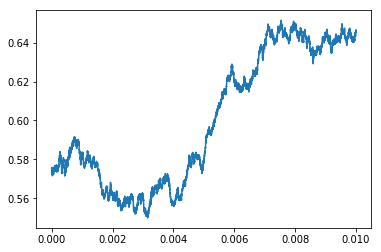

In [5]:
# simulating 2D gaussian illumination with variance = 1
# This is to generate the intensity at each point in time
# The intensities are found at each point by summing each the intensities of
# every particles
intensity = norm.pdf(path,loc=0)
intensity = np.sum(intensity,axis=0) # moving to 1 dimension
tt = np.arange(length+1)*dt # time-axis t[-1]=T
plt.plot(tt,intensity)

59

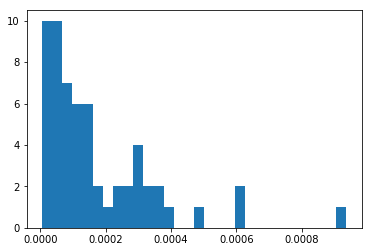

In [6]:
# Multiply by the maximum intensity and then interpolate the 
# the intensities with the total time
Imax = 10000
intensity_interp = interp1d(tt,intensity*Imax)
# Interpolating the intensity so we can jump by any interval in time
# The time step is determined by dt
# The intensity at each point is found by using the interpolated function and the current timepoint
t = 0
delta_t_list=[]
while t < tt[-1]:
    current_int = intensity_interp(t)
    delta_t = np.random.exponential(1/current_int)
    delta_t_list.append(delta_t)
    t = t + delta_t
plt.hist(delta_t_list,bins=30)
len(delta_t_list)

In [7]:
# Catches the delta_Ts into a list
delta_t_list = np.array(delta_t_list)
delta_t_list.sort(axis=0)

In [8]:
# likelihood function
def p_dt_int(x,flux):
    return np.exp(-flux*x)/np.sqrt(-np.log(x))
def p_dt(flux):
    return np.array([quad(p_dt_int,0,1,args=(f))[0] for f in flux])

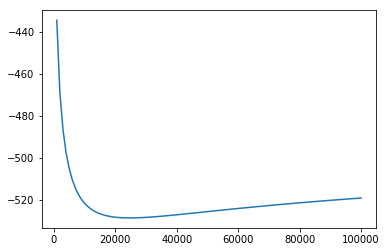

In [12]:
# The likelihood function is mapped out by sampling different points
# Note that we are using the negative of this function to make the maximum
# a minimum to allow us to use already existing optimization functions
I0 = 0
tt = []
s = []
for i in range(100):
    I0 = I0+1000;
    tt.append(I0)
    s.append(-N*np.log(I0)-np.sum(np.log(p_dt(I0*delta_t_list))))
plt.plot(tt,s)

In [11]:
# we find the minimum using Nelder mead in this case to find the 
# Io that gives us the best result
p = lm.Parameters()
p.add('I0',value=1000)
N = len(delta_t_list)
def residual(p):
    return -N*np.log(p['I0'])-np.sum(np.log(p_dt(p['I0']*delta_t_list)))
mini = lm.Minimizer(residual,p,nan_policy='omit')
out1 = mini.minimize(method='Nelder')
lm.report_fit(out1.params, min_correl=0.5)

[[Variables]]
    I0:  24749.0723 (init = 1000)


C:\Users\mebra\Anaconda3\lib\site-packages\lmfit\minimizer.py:335: RuntimeWarning: divide by zero encountered in double_scalars
  self.redchi = self.chisqr / self.nfree
